In [68]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2)
])

# download the fashion mnist dataset
train_dataset = datasets.FashionMNIST(root='data', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', download=True, train=False, transform=transform)

BATCH_SIZE = 100
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [69]:
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Pad(padding=2, fill=0, padding_mode=constant)
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Pad(padding=2, fill=0, padding_mode=constant)
            ))

In [70]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [71]:
for image, label in train_dataset:
    print(image.shape, label)
    break

torch.Size([1, 32, 32]) 9


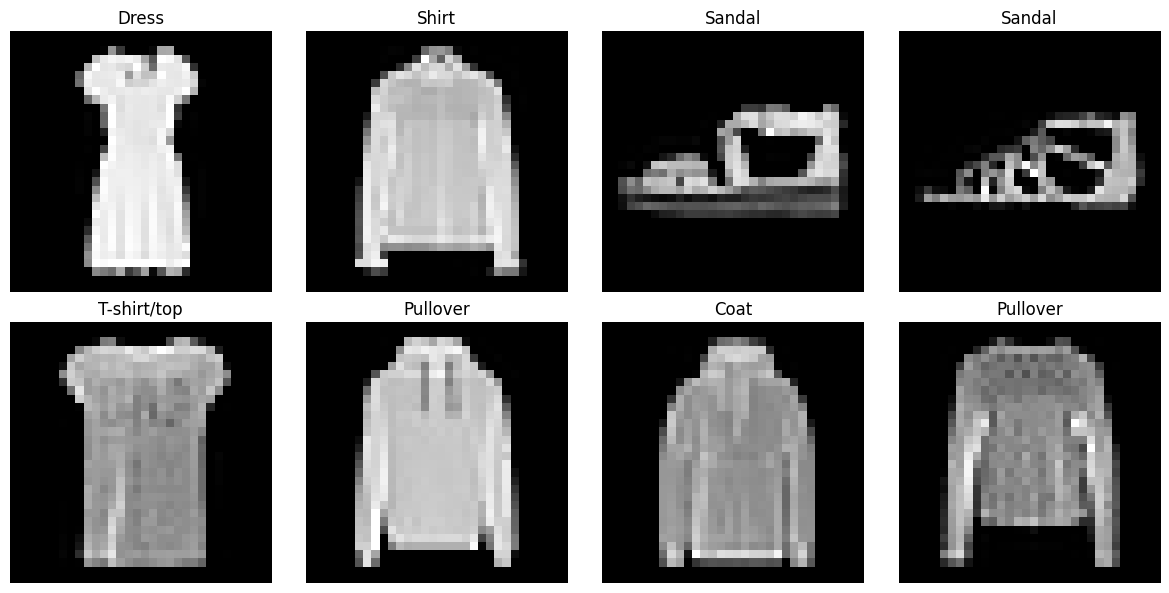

In [72]:
# Plot 8 random images from the train_dataset in 2 rows along with the labels (class names) as title
import matplotlib.pyplot as plt
import numpy as np

def plot_random_images(dataset, class_names, num_images=8):
    indices = np.random.choice(range(len(dataset)), num_images, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.numpy().squeeze()
        ax = axes[i//4, i%4]
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[label])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_random_images(train_dataset, class_names)


### The Encoder

In [73]:
from torch import nn
class EncoderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*4*4, 2)
        )

    def forward(self, x):
        return self.encoder(x)

In [74]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

mps


In [75]:
from torchsummary import summary

torch.manual_seed(42)

encoder = EncoderModel()
summary(encoder, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.37
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [76]:
class DecoderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(2, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [77]:
from torchsummary import summary

# Set the seed for reproducibility
torch.manual_seed(42)

# Instantiate the decoder model
decoder = DecoderModel()

# Print the model summary
summary(decoder, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
              ReLU-2                 [-1, 2048]               0
         Unflatten-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         147,584
              ReLU-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6           [-1, 64, 16, 16]          73,792
              ReLU-7           [-1, 64, 16, 16]               0
   ConvTranspose2d-8           [-1, 32, 32, 32]          18,464
              ReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10            [-1, 1, 32, 32]             289
          Sigmoid-11            [-1, 1, 32, 32]               0
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [78]:
class AutoencoderModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
encoder = EncoderModel()
decoder = DecoderModel()

autoencoder = AutoencoderModel(encoder, decoder)

from torchsummary import summary
summary(autoencoder, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
      EncoderModel-9                    [-1, 2]               0
           Linear-10                 [-1, 2048]           6,144
             ReLU-11                 [-1, 2048]               0
        Unflatten-12            [-1, 128, 4, 4]               0
  ConvTranspose2d-13            [-1, 128, 8, 8]         147,584
             ReLU-14            [-1, 12

In [79]:
from torch import optim

torch.manual_seed(42)
encoder = EncoderModel()
decoder = DecoderModel()

autoencoder = AutoencoderModel(encoder, decoder)
autoencoder.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = autoencoder(inputs)

        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

Epoch [1/20], Train Loss: 0.2922
Epoch [2/20], Train Loss: 0.2583
Epoch [3/20], Train Loss: 0.2543
Epoch [4/20], Train Loss: 0.2522
Epoch [5/20], Train Loss: 0.2507
Epoch [6/20], Train Loss: 0.2494
Epoch [7/20], Train Loss: 0.2486
Epoch [8/20], Train Loss: 0.2476
Epoch [9/20], Train Loss: 0.2468
Epoch [10/20], Train Loss: 0.2463
Epoch [11/20], Train Loss: 0.2457
Epoch [12/20], Train Loss: 0.2452
Epoch [13/20], Train Loss: 0.2447
Epoch [14/20], Train Loss: 0.2444
Epoch [15/20], Train Loss: 0.2441
Epoch [16/20], Train Loss: 0.2437
Epoch [17/20], Train Loss: 0.2433
Epoch [18/20], Train Loss: 0.2432
Epoch [19/20], Train Loss: 0.2429
Epoch [20/20], Train Loss: 0.2427


In [80]:
# Testing loop
autoencoder.eval()
test_loss = 0.0
with torch.inference_mode():
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        outputs = autoencoder(inputs)

        loss = criterion(outputs, inputs)

        test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.2464


In [81]:
test_dataset


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=2, fill=0, padding_mode=constant)
           )

In [82]:
example_images = test_dataset.data[:5000].unsqueeze(1).float() / 255.0
example_images = example_images.to(device)

autoencoder.eval()

with torch.inference_mode():
    predictions = autoencoder(example_images)

predictions = predictions.cpu()

print(predictions.shape)

torch.Size([5000, 1, 32, 32])


Text(0.5, 1.0, 'Reconstructed Images')

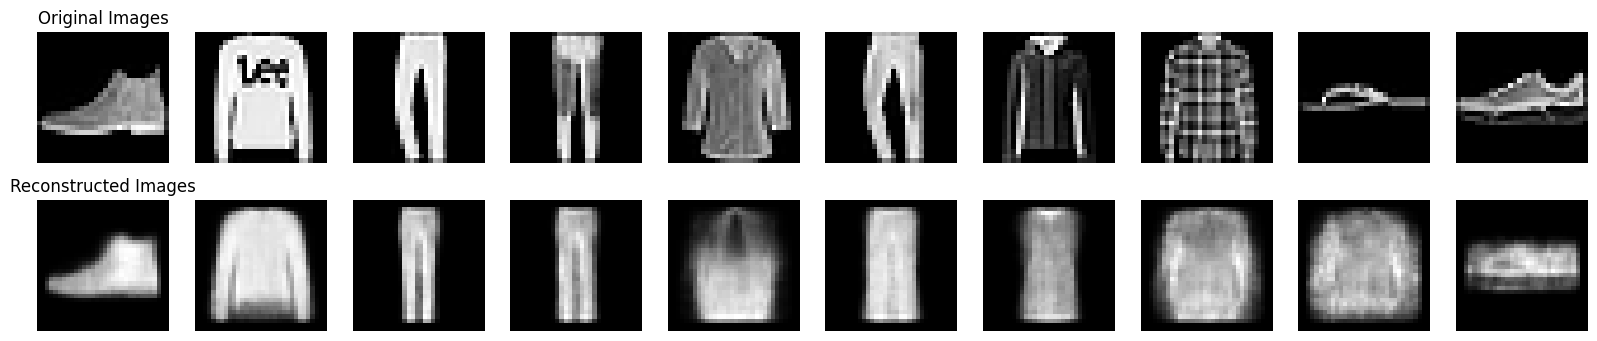

In [83]:
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axes[0, i].imshow(example_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(predictions[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')

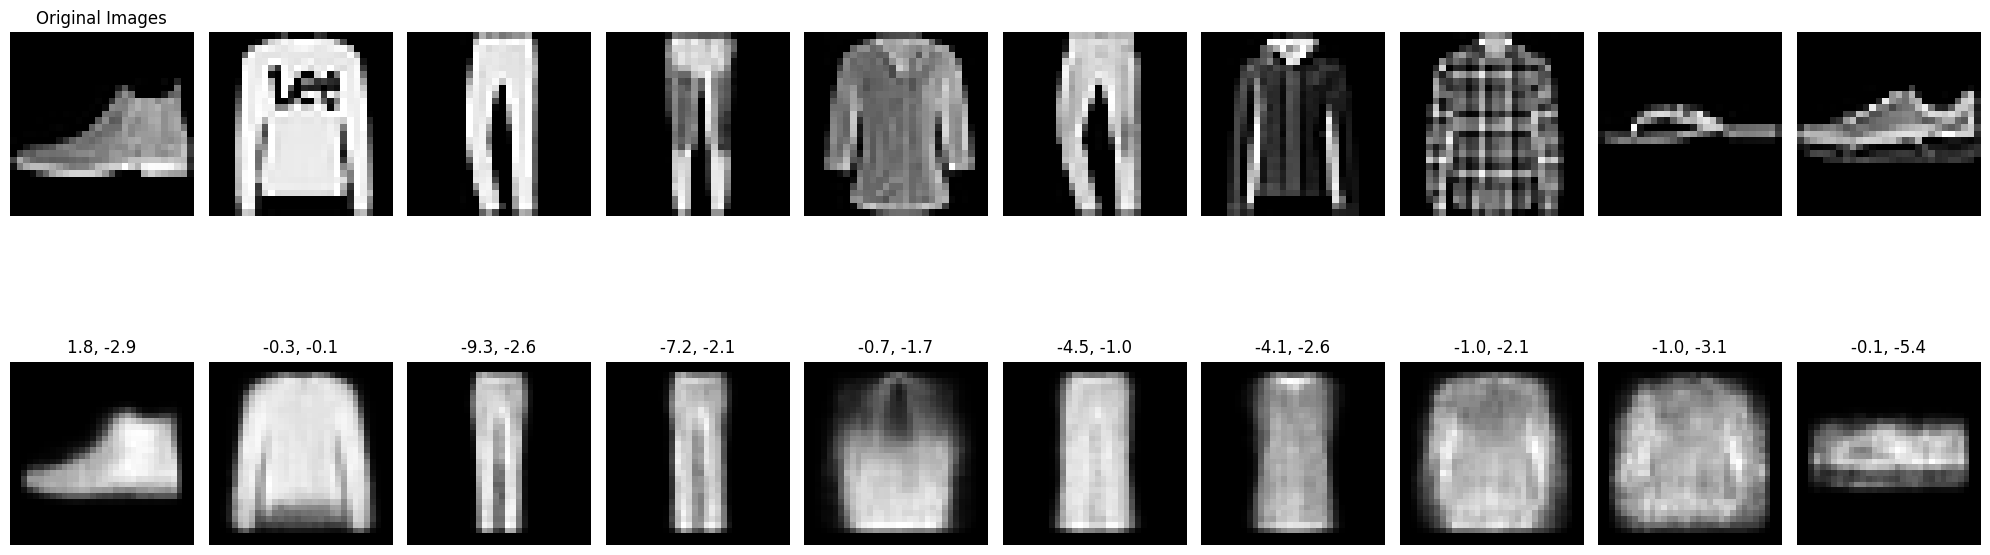

In [84]:
example_images = test_dataset.data[:5000].unsqueeze(1).float() / 255.0
example_images = example_images.to(device)

autoencoder.eval()

# Perform the predictions
with torch.no_grad():  # Disable gradient calculation
    latent_encodings = autoencoder.encoder(example_images)
    predictions = autoencoder.decoder(latent_encodings)

# Move predictions and latent encodings back to CPU and convert to numpy
predictions = predictions.cpu()
latent_encodings = latent_encodings.cpu().numpy()

# Plot the images and latent encodings
fig, axes = plt.subplots(2, 10, figsize=(20, 8))

for i in range(10):
    # Original images
    axes[0, i].imshow(example_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    
    # Reconstructed images with latent encodings as title
    axes[1, i].imshow(predictions[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"{latent_encodings[i][0]:.1f}, {latent_encodings[i][1]:.1f}", fontsize=12)
    axes[1, i].axis('off')

axes[0, 0].set_title('Original Images')
# axes[1, 0].set_title('Reconstructed Images with Latent Encodings')

plt.tight_layout()
plt.show()

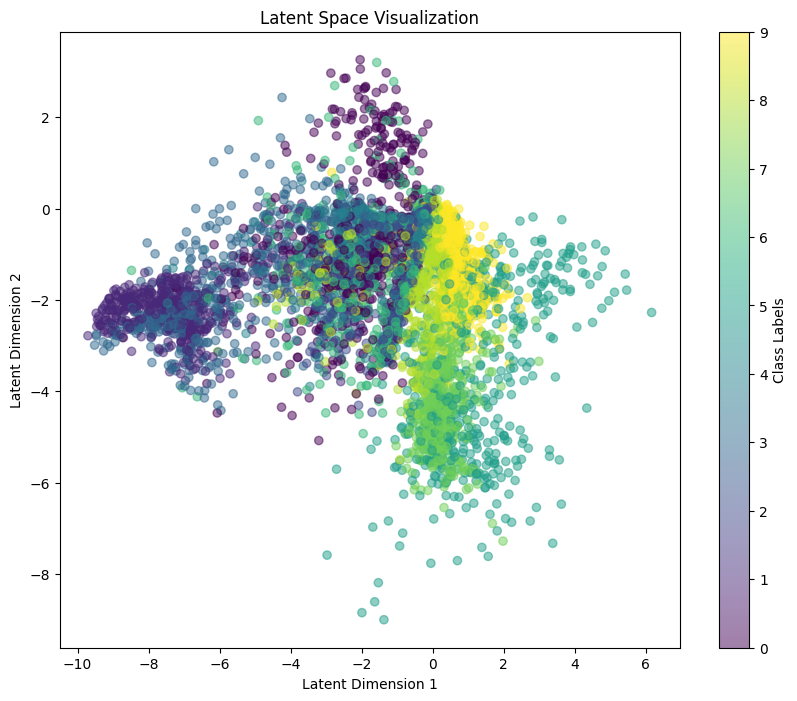

In [85]:
# Prepare the example images and labels (first 5000 images from the test dataset)
example_images = test_dataset.data[:5000].unsqueeze(1).float() / 255.0  # Normalize the images
example_labels = test_dataset.targets[:5000]  # Get the labels
example_images = example_images.to(device)  # Move to the appropriate device

# Set the model to evaluation mode
autoencoder.eval()

# Perform the predictions
with torch.no_grad():  # Disable gradient calculation
    latent_encodings = autoencoder.encoder(example_images)

# Move latent encodings back to CPU and convert to numpy
latent_encodings = latent_encodings.cpu().numpy()
example_labels = example_labels.numpy()

# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_encodings[:, 0], latent_encodings[:, 1], c=example_labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Class Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

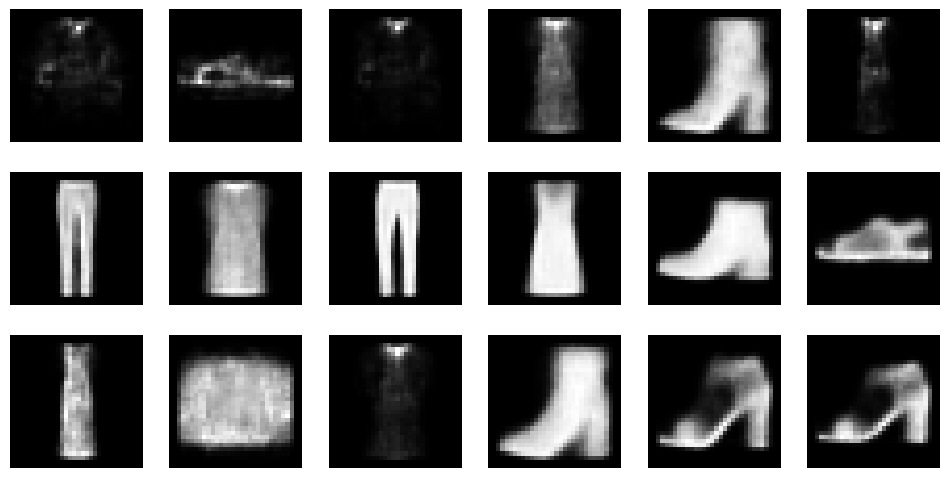

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming autoencoder and decoder are already defined and trained

# Set the model to evaluation mode
autoencoder.eval()

# Prepare the example images (first 5000 images from the test dataset)
example_images = test_dataset.data[:5000].unsqueeze(1).float() / 255.0  # Normalize the images
example_images = example_images.to(device)  # Move to the appropriate device

# Perform the predictions to get latent encodings
with torch.no_grad():  # Disable gradient calculation
    latent_encodings = autoencoder.encoder(example_images)

# Move latent encodings back to CPU and convert to numpy
latent_encodings = latent_encodings.cpu().numpy()

# Calculate the minimum and maximum values of the latent encodings
mins, maxs = np.min(latent_encodings, axis=0), np.max(latent_encodings, axis=0)

# Generate random samples uniformly distributed between the minimum and maximum values
sample = np.random.uniform(mins, maxs, size=(18, 2))

# Convert the sample to a PyTorch tensor and move to the appropriate device
sample_tensor = torch.tensor(sample, dtype=torch.float32).to(device)

# Perform the reconstructions using the decoder
with torch.no_grad():  # Disable gradient calculation
    reconstructions = autoencoder.decoder(sample_tensor)

# Move reconstructions back to CPU
reconstructions = reconstructions.cpu()

# Plot the reconstructions
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructions[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.show()